In [ ]:
rm -rf pythia_tools

In [ ]:
!git clone https://github.com/kmrasmussen/pythia_tools.git pythia_tools
!pip install -e pythia_tools --quiet
!pip install git+https://github.com/neelnanda-io/TransformerLens.git --quiet

Cloning into 'pythia_tools'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 113 (delta 39), reused 57 (delta 20), pack-reused 34
Receiving objects: 100% (113/113), 57.72 MiB | 27.26 MiB/s, done.
Resolving deltas: 100% (43/43), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 99.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 100.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import sys
sys.path.append("pythia_tools")
from pythia_tools.models import get_model, yield_models, get_n_layers
from tqdm import tqdm
from pythia_tools.visualization import hist_and_box
from transformer_lens import HookedTransformer
from pythia_tools.data import get_token_mat
import torch.nn.functional as F

In [ ]:
def get_many_post_all_layers(model, seq_ids, T, hook_name='mlp.hook_post'):
  pres = []
  for seq_id in tqdm(seq_ids):
    logits, cache = model.run_with_cache(T[seq_id], prepend_bos=False, remove_batch_dim=True)
    pre = [torch.clone(cache[f'blocks.{layer}.{hook_name}']) for layer in range(get_n_layers(model))]
    del logits
    del cache
    torch.cuda.empty_cache()
    pres.append(torch.stack(pre))
    del pre
  ret = torch.stack(pres)
  del pres
  return ret # seqs, layers, position, neurons

In [ ]:
T = get_token_mat()

torch.Size([10691, 600])


Using pad_token, but it is not set yet.


Loaded pretrained model pythia-70m-deduped into HookedTransformer


100%|██████████| 10/10 [00:00<00:00, 18.60it/s]


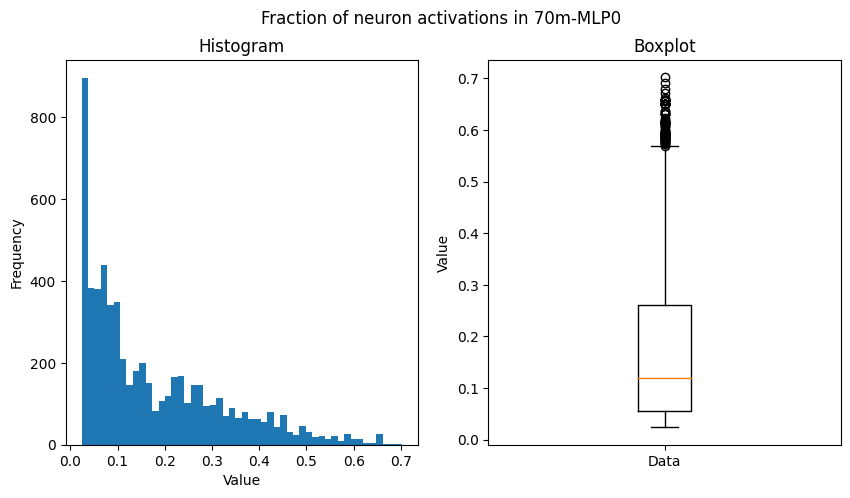

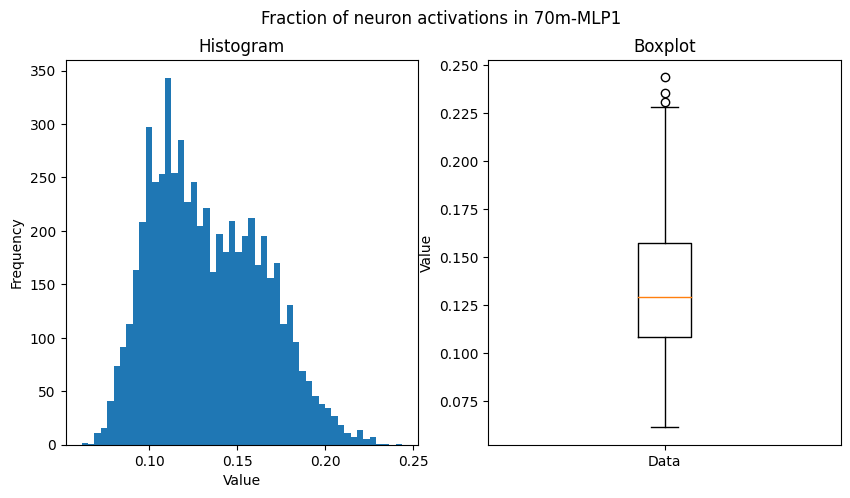

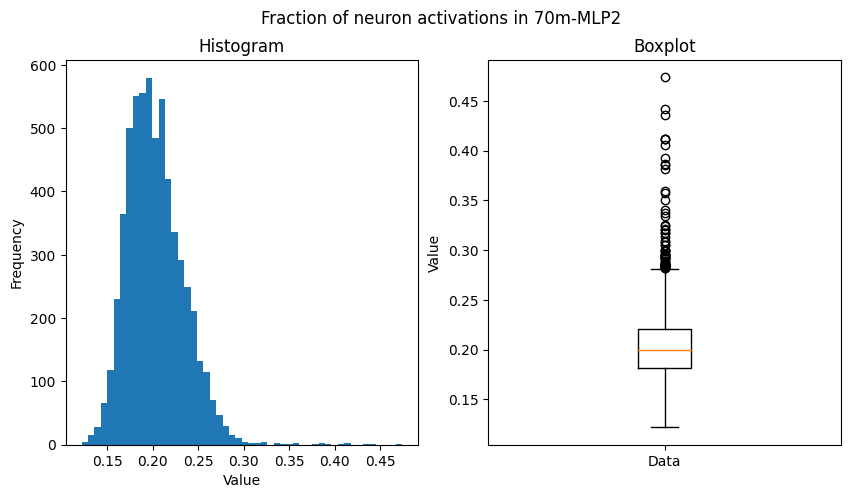

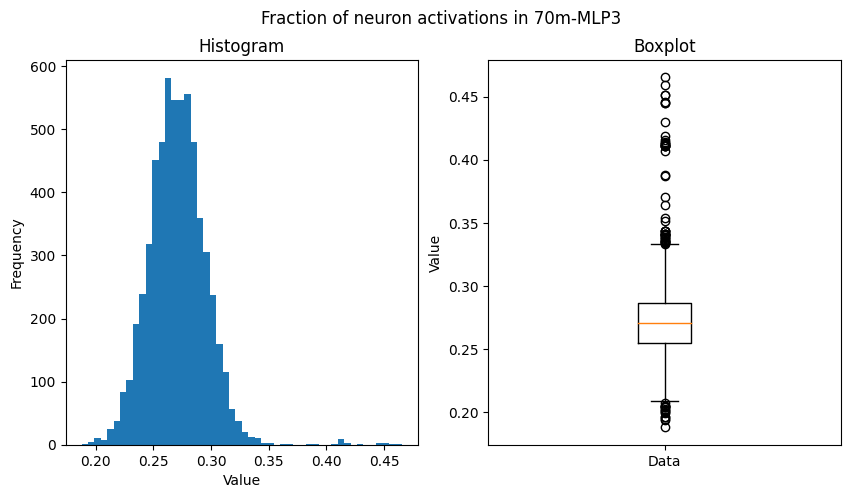

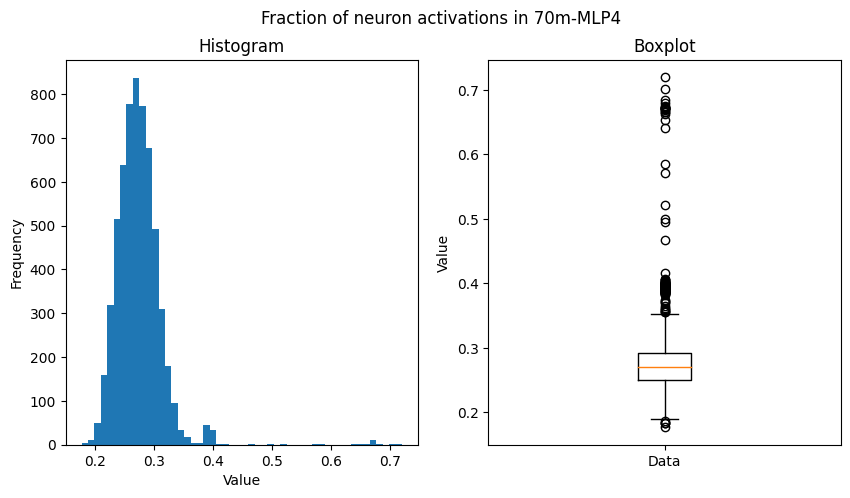

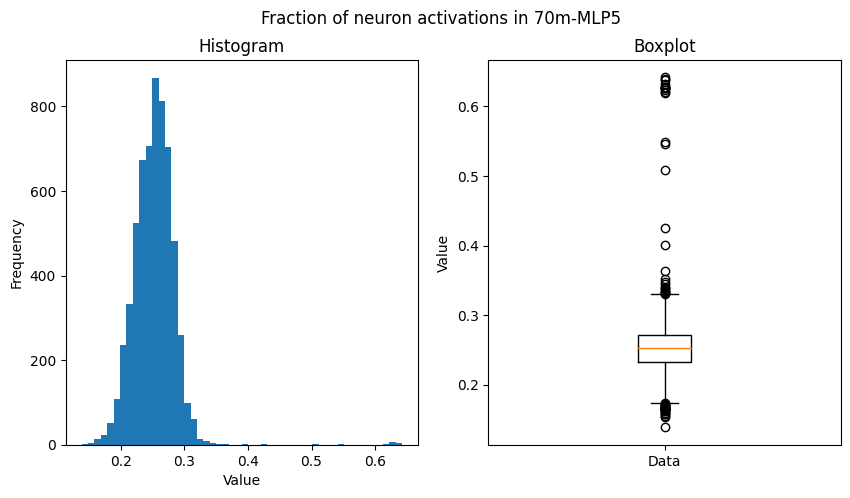

Using pad_token, but it is not set yet.


Loaded pretrained model pythia-160m-deduped into HookedTransformer


100%|██████████| 10/10 [00:01<00:00,  9.08it/s]


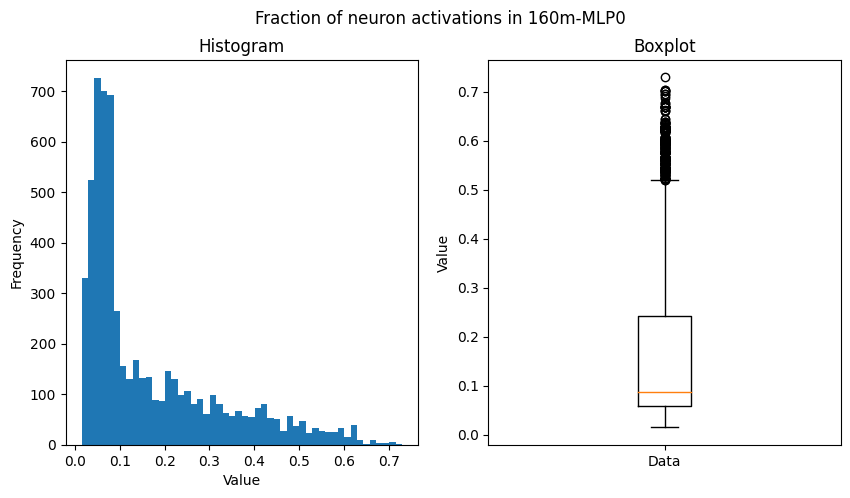

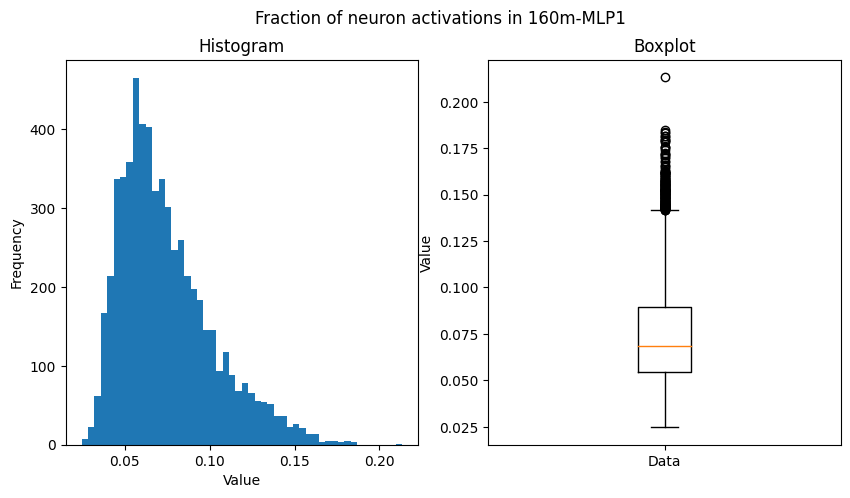

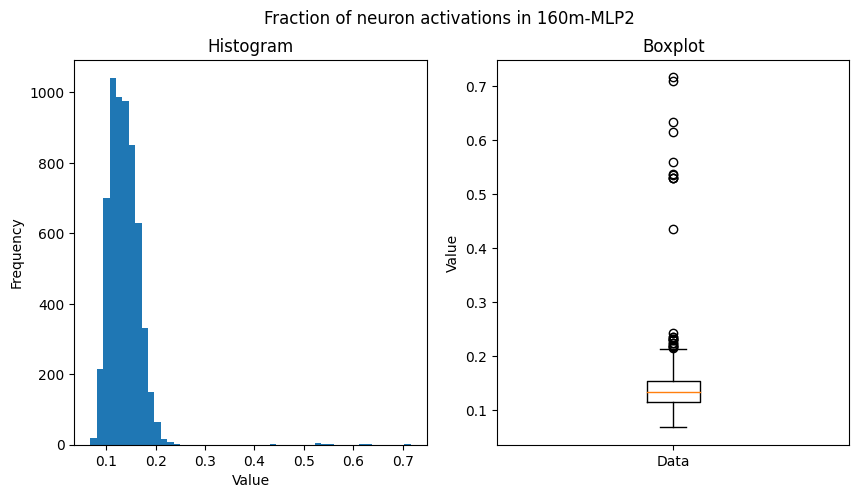

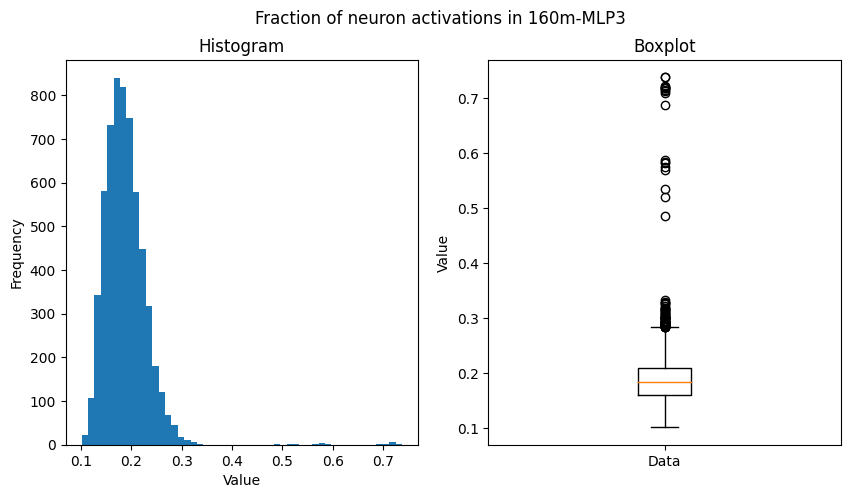

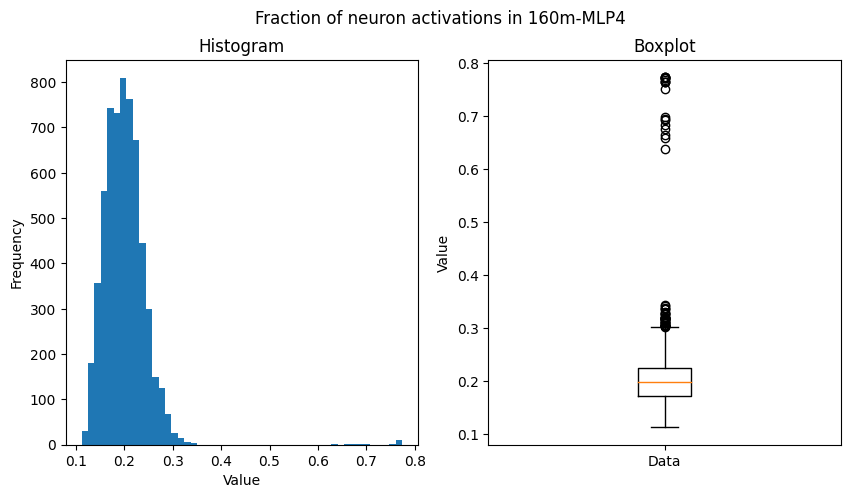

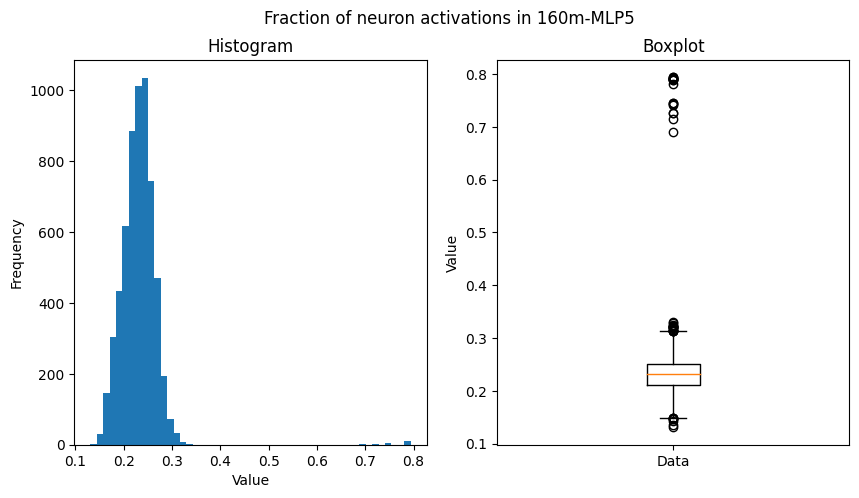

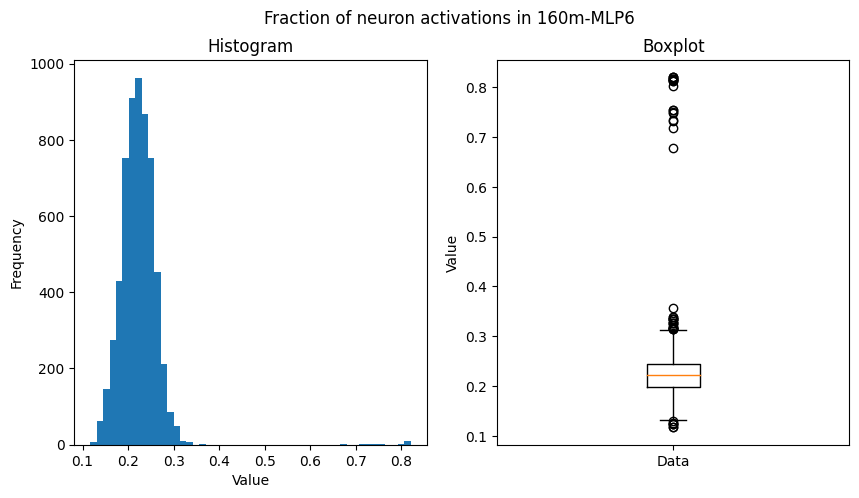

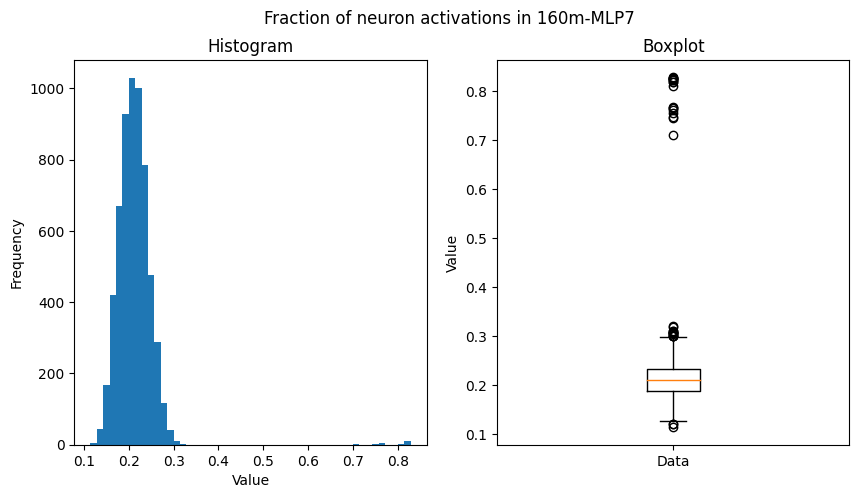

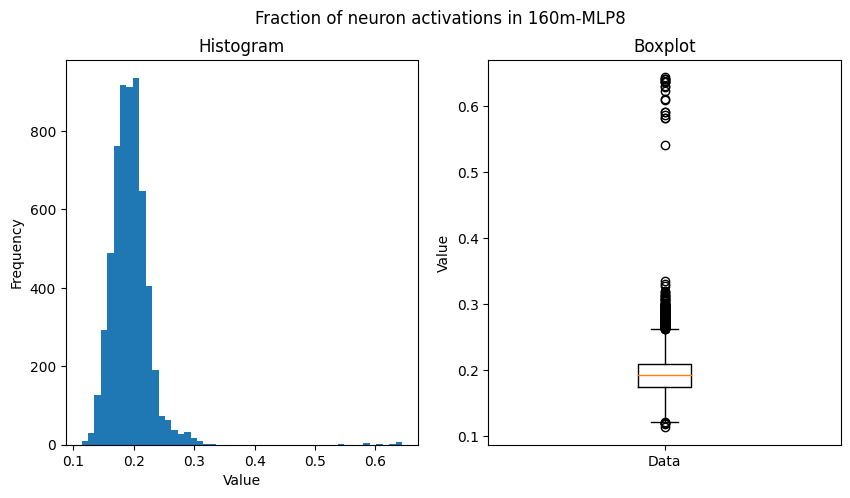

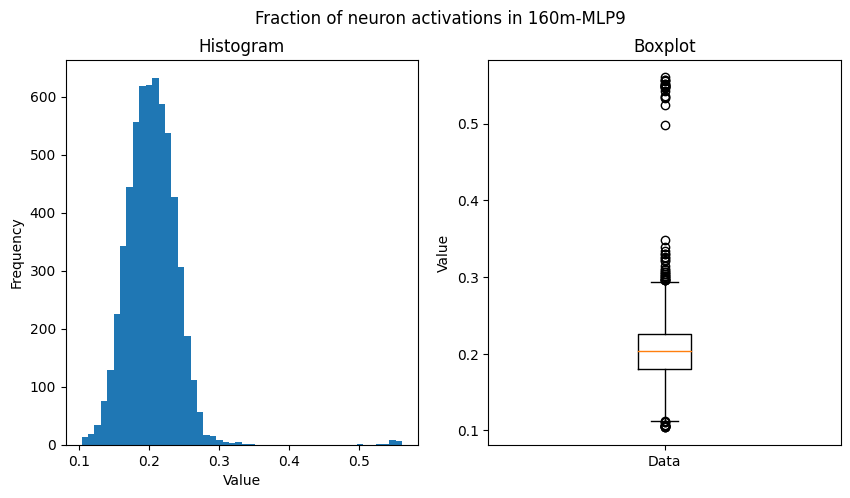

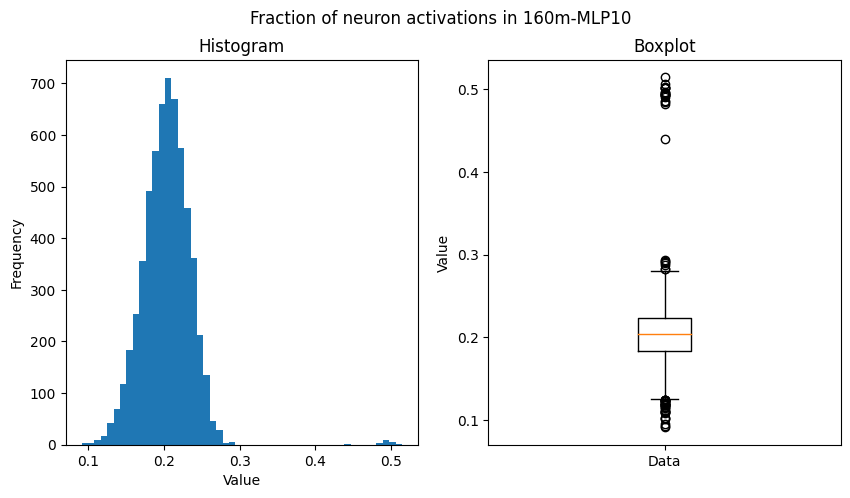

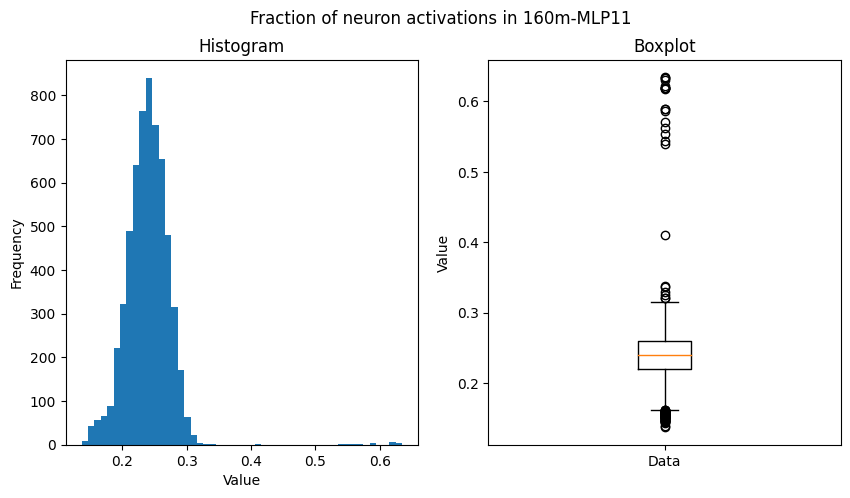

Using pad_token, but it is not set yet.


Loaded pretrained model pythia-410m-deduped into HookedTransformer


100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


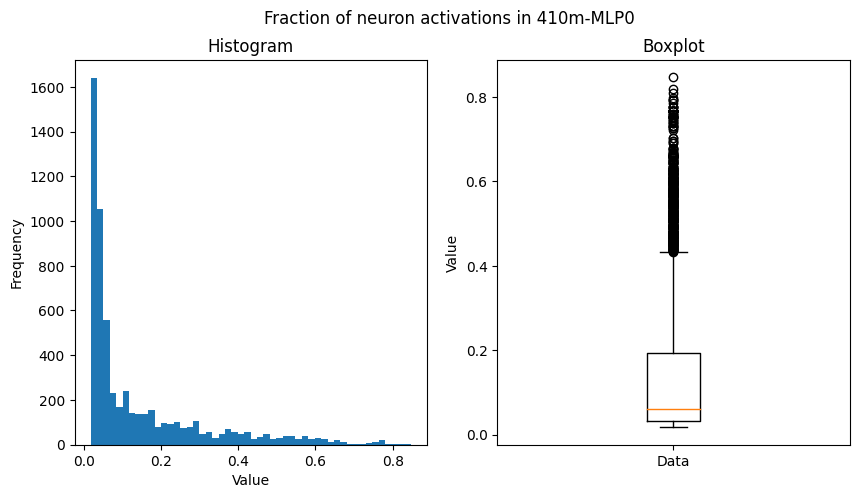

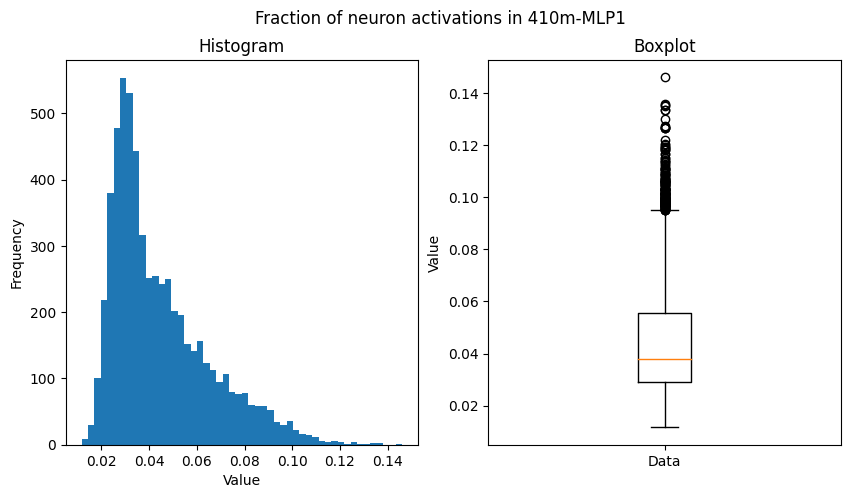

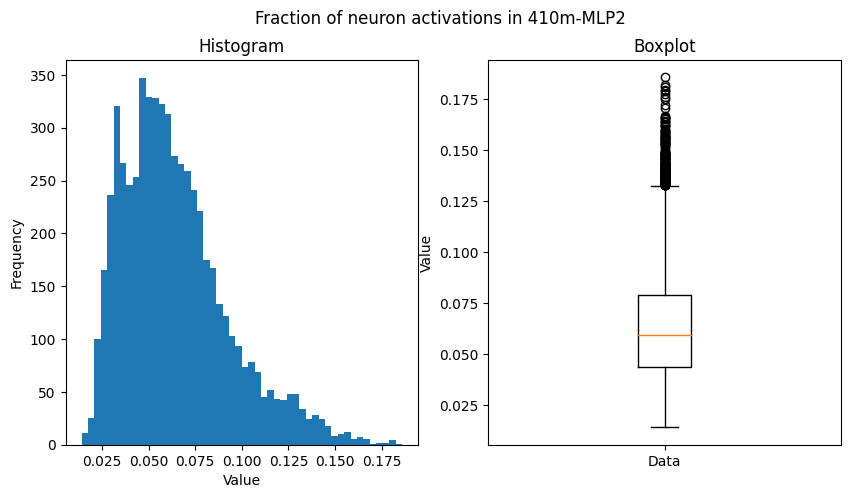

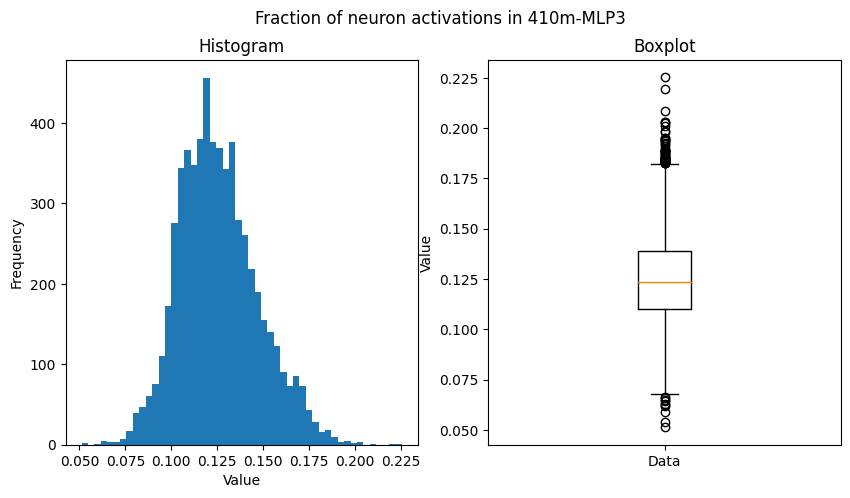

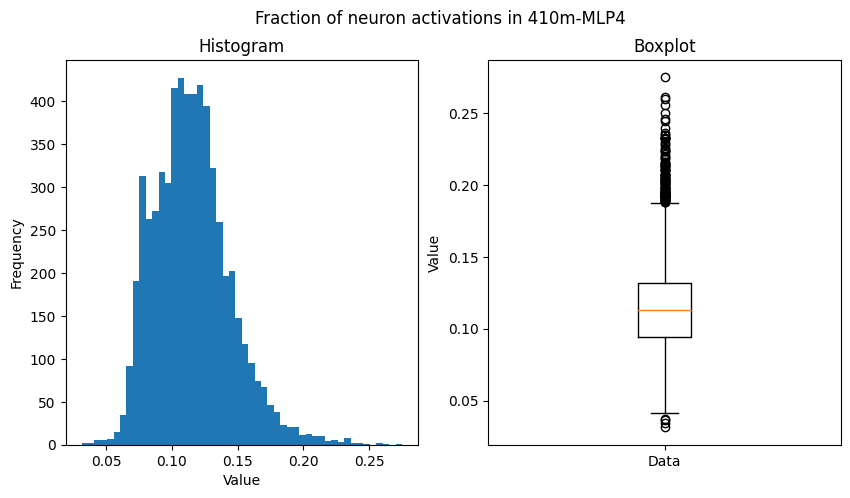

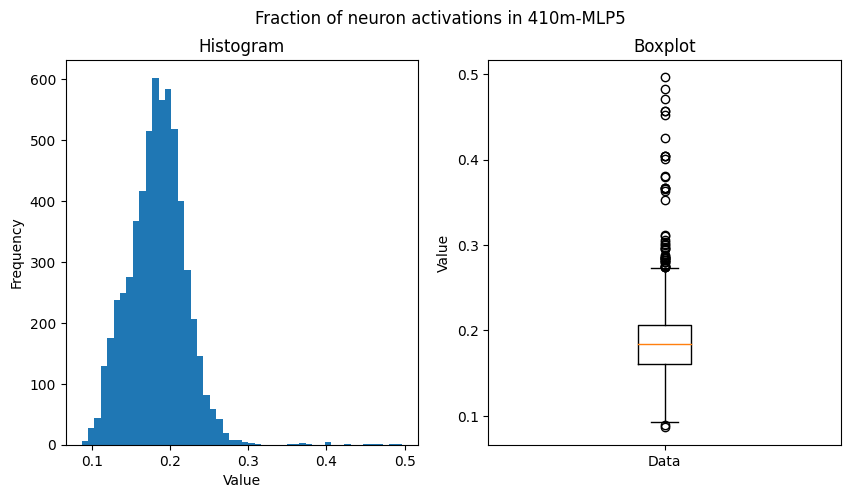

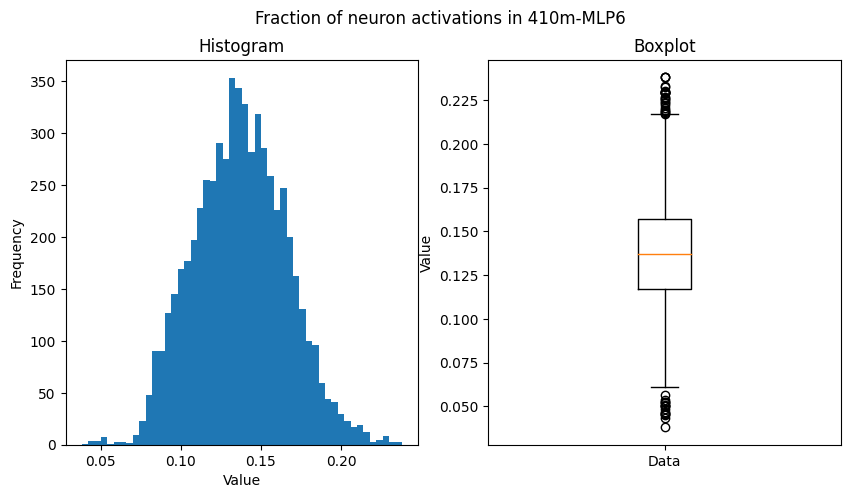

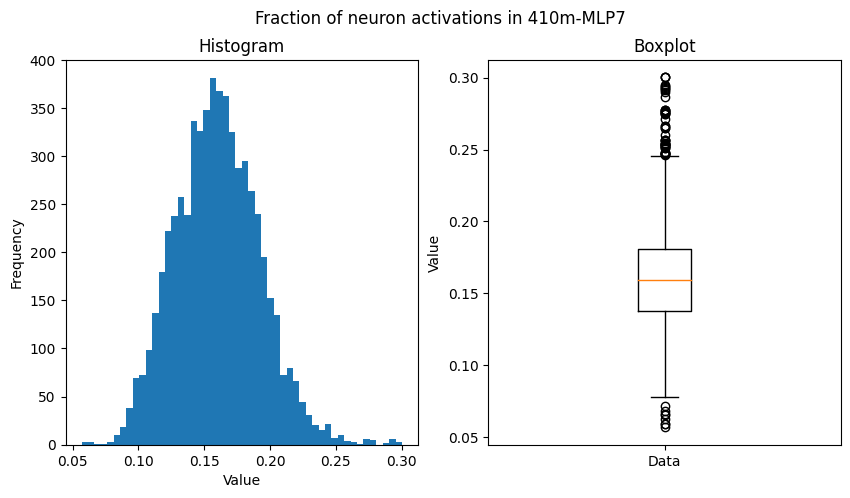

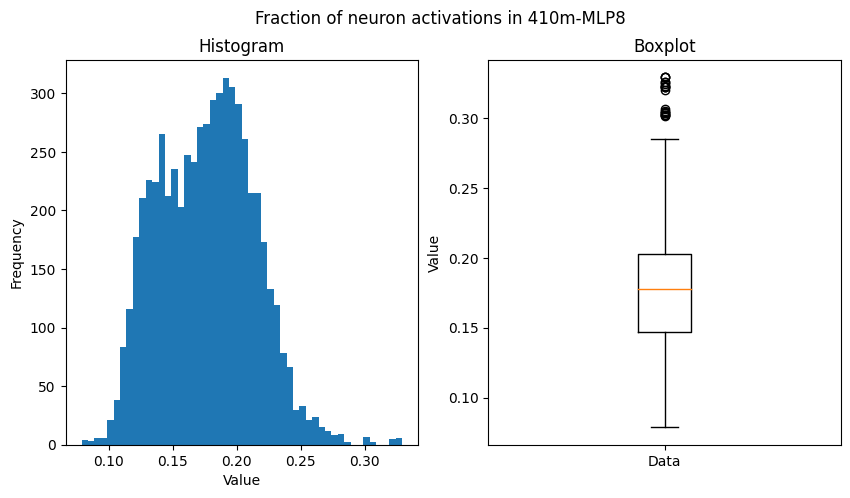

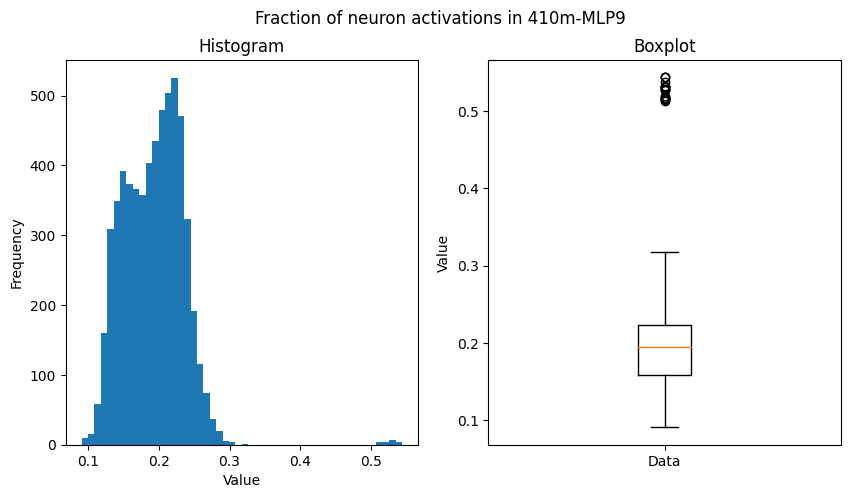

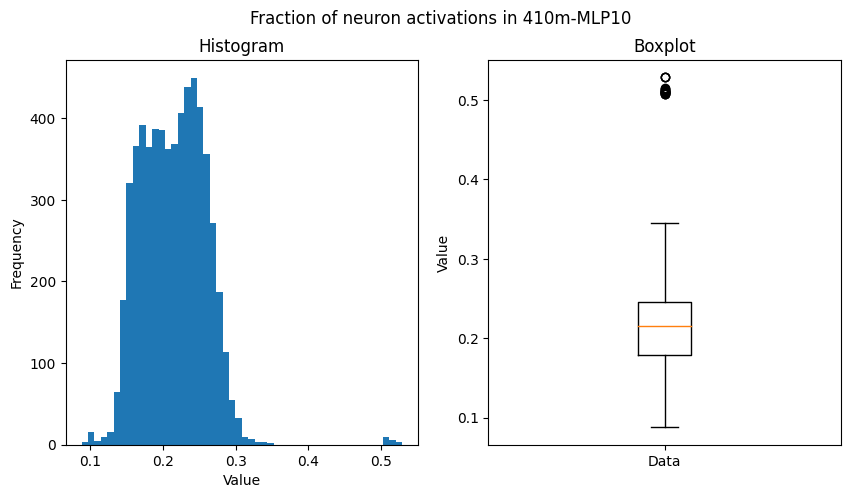

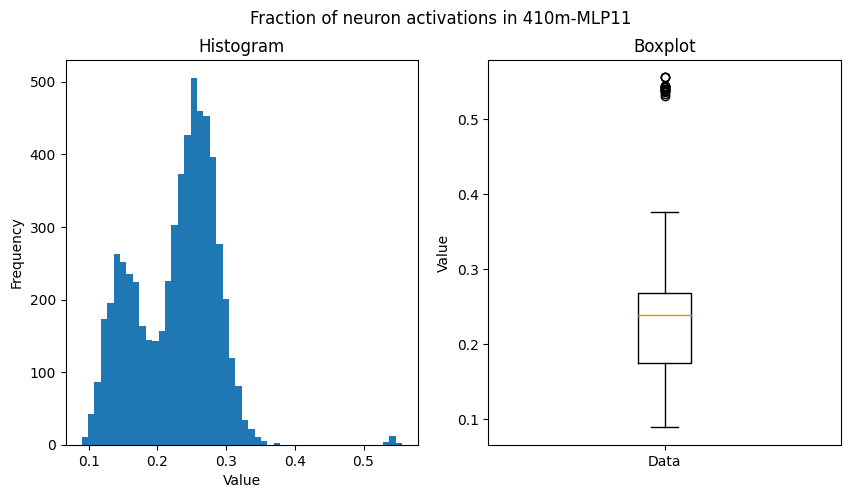

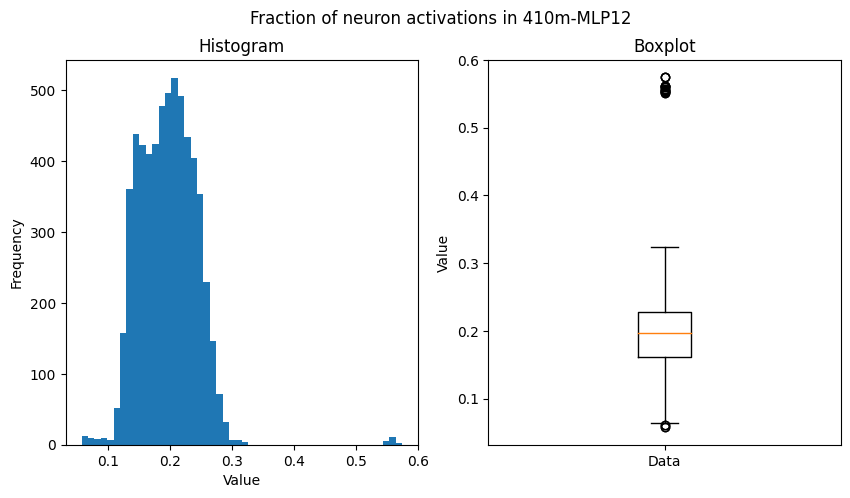

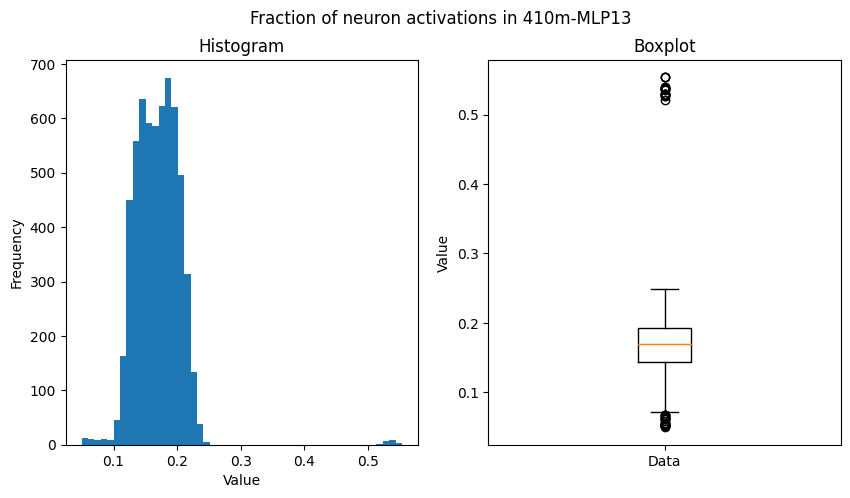

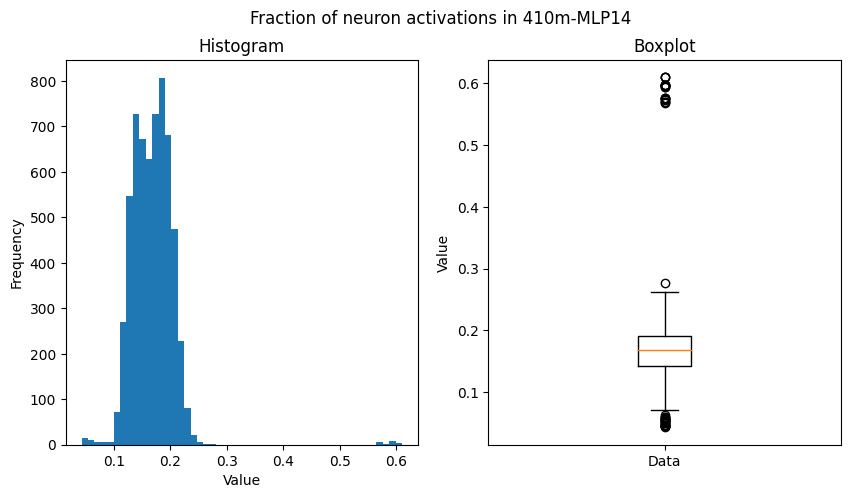

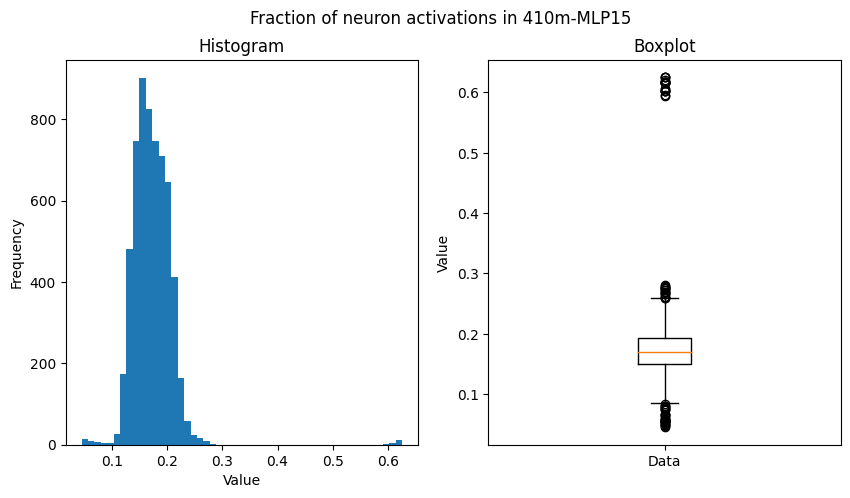

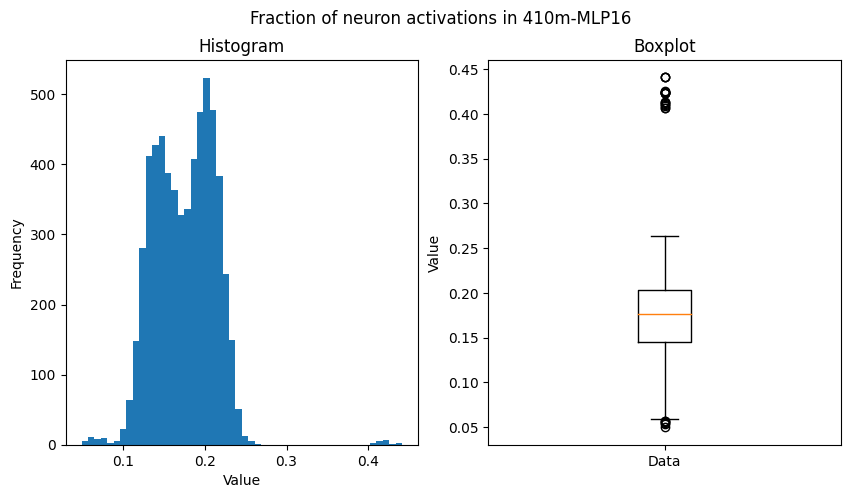

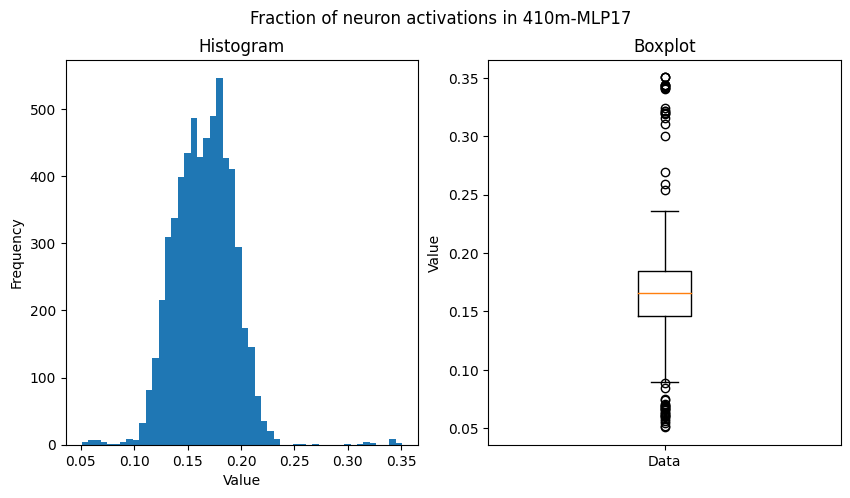

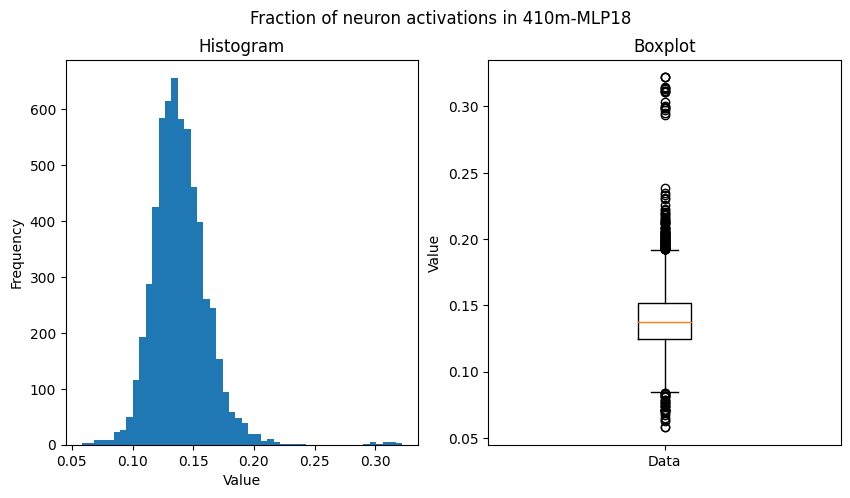

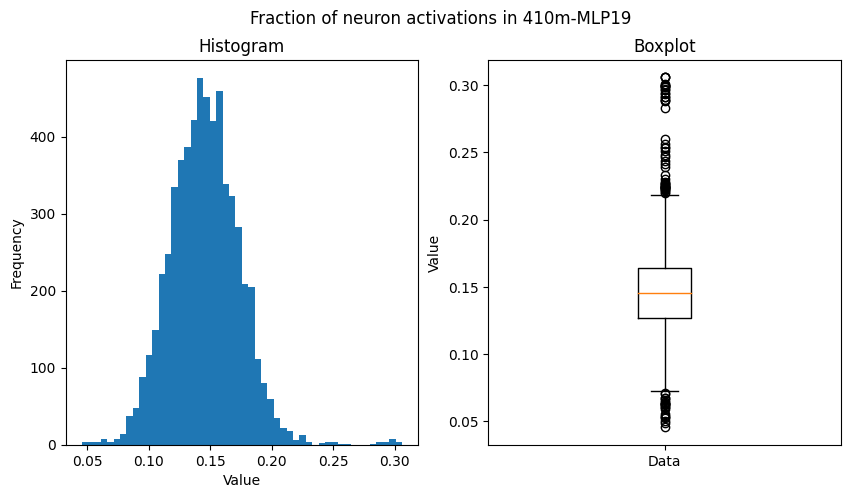

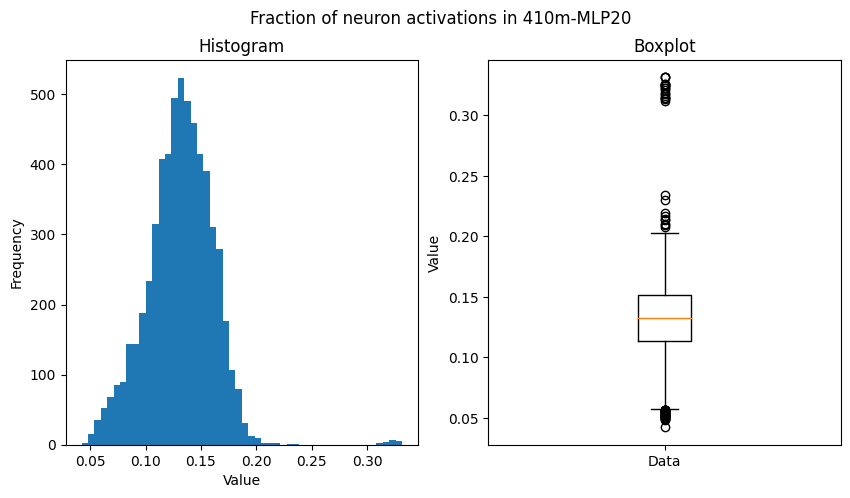

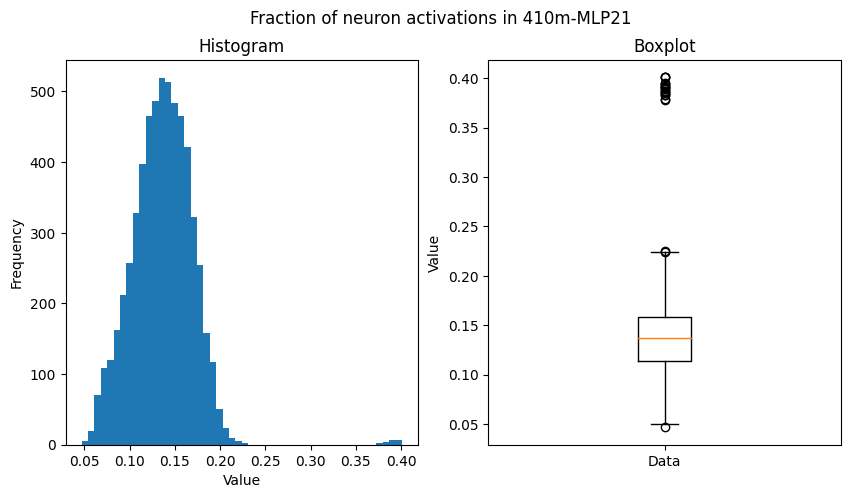

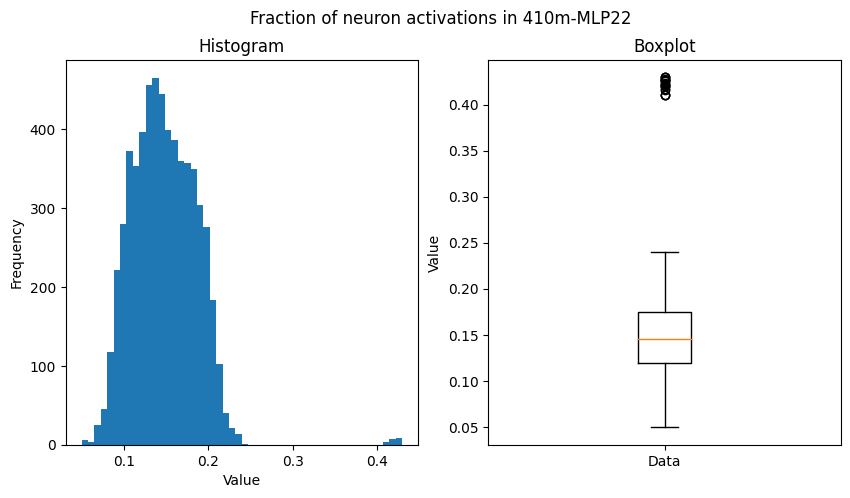

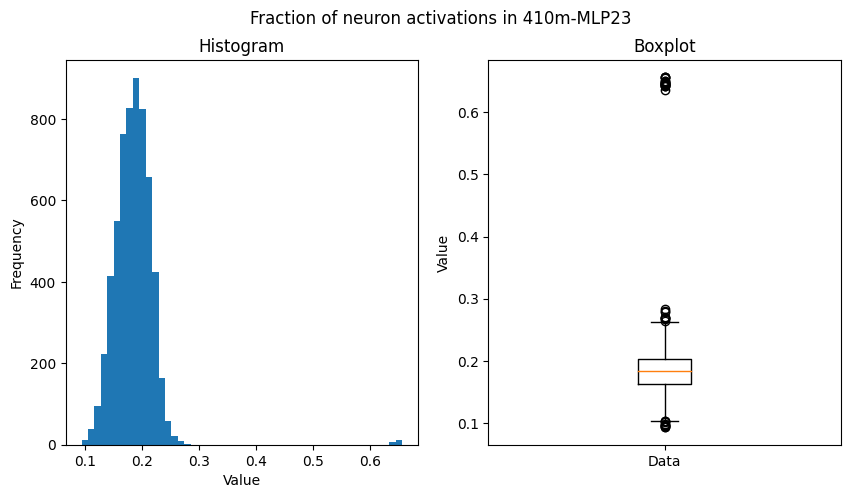

Using pad_token, but it is not set yet.


Loaded pretrained model pythia-1b-deduped into HookedTransformer


100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


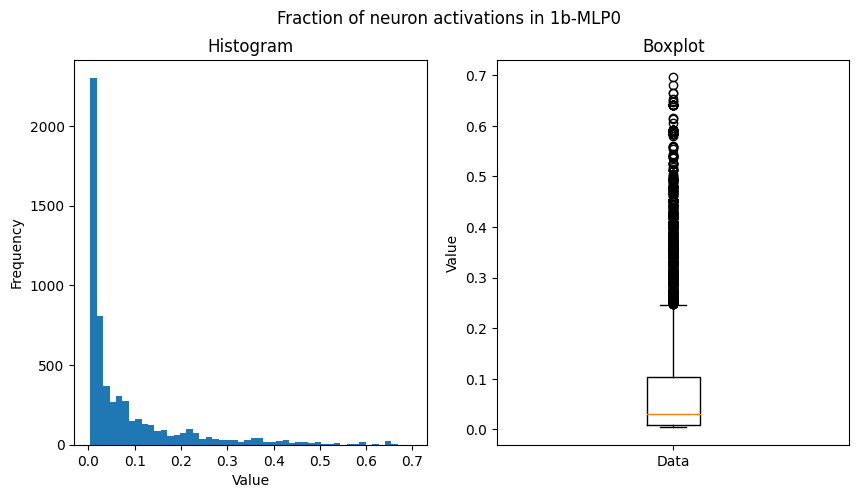

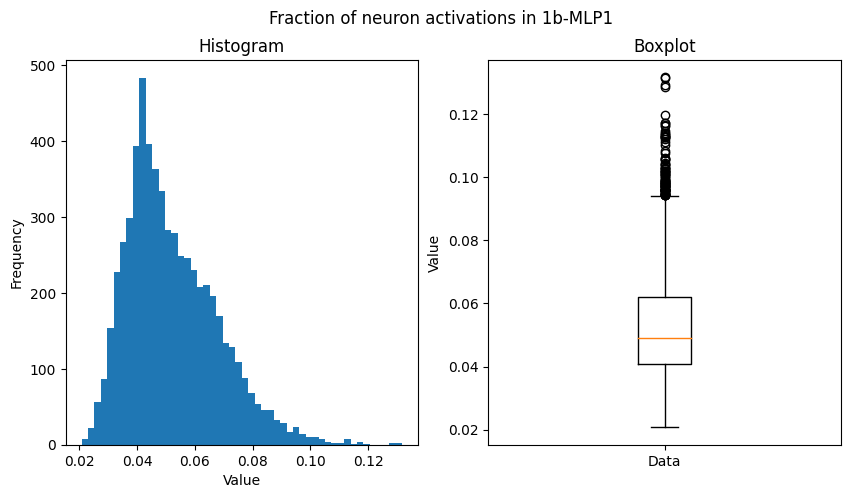

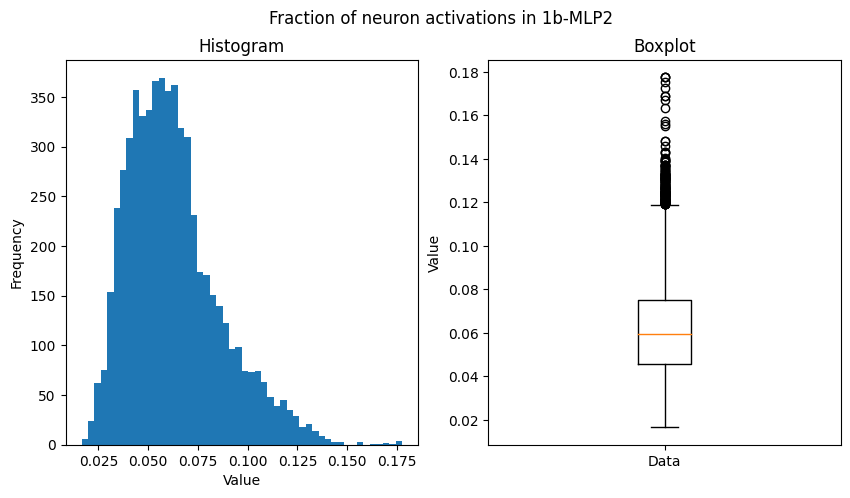

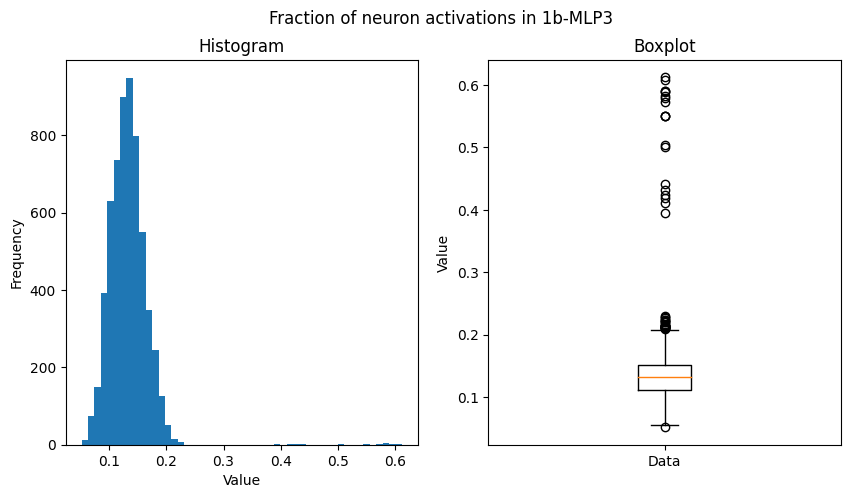

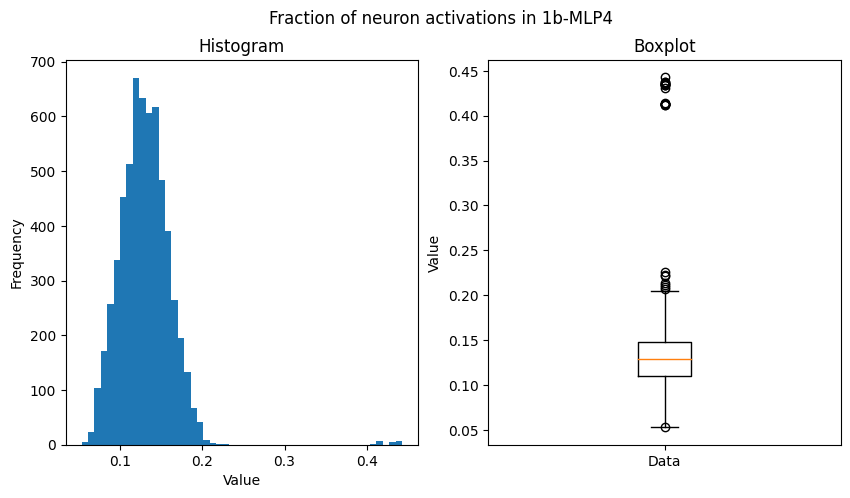

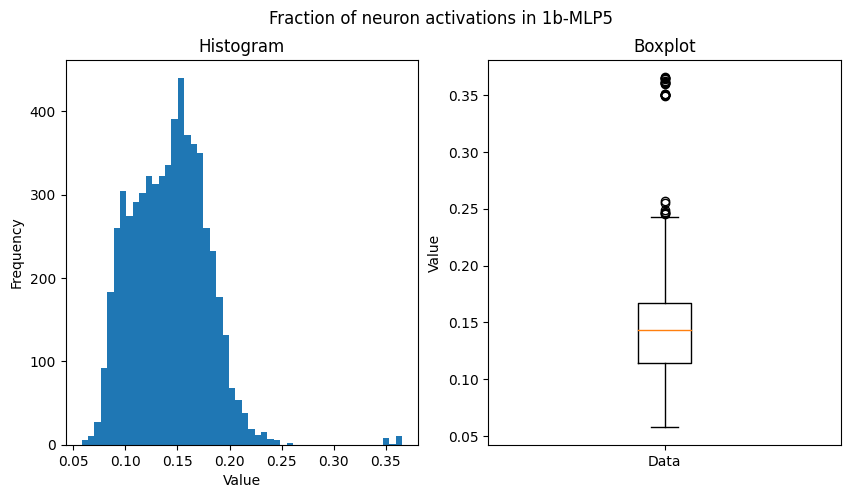

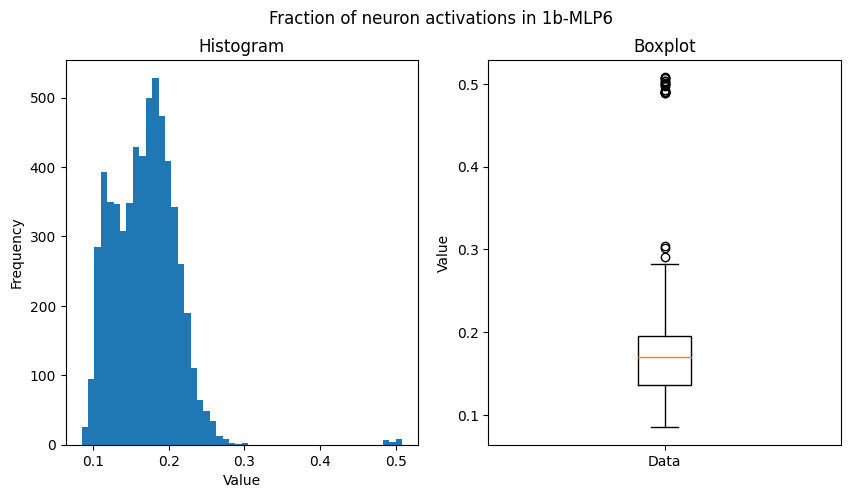

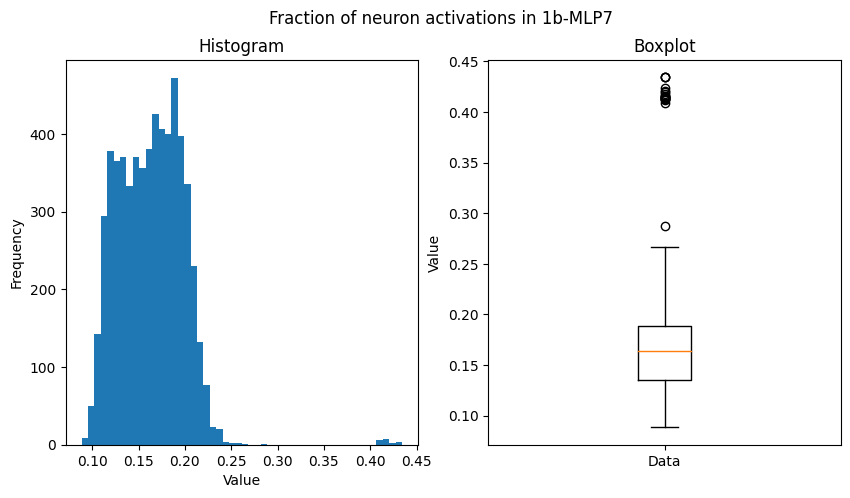

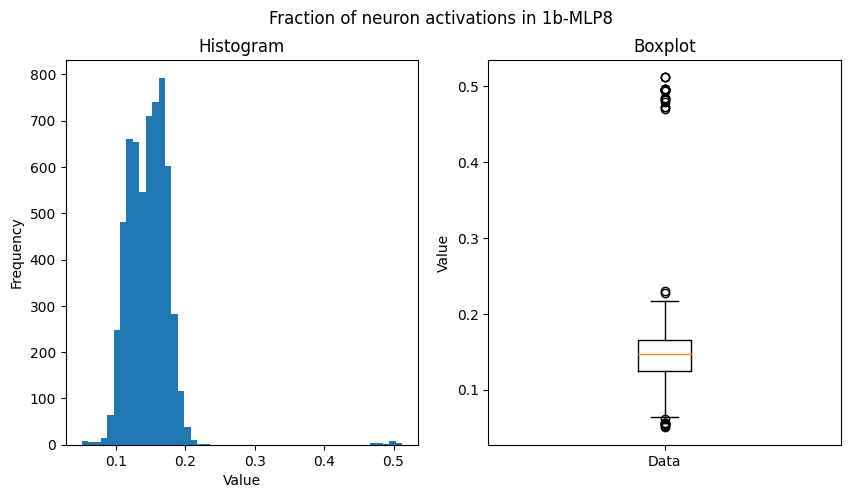

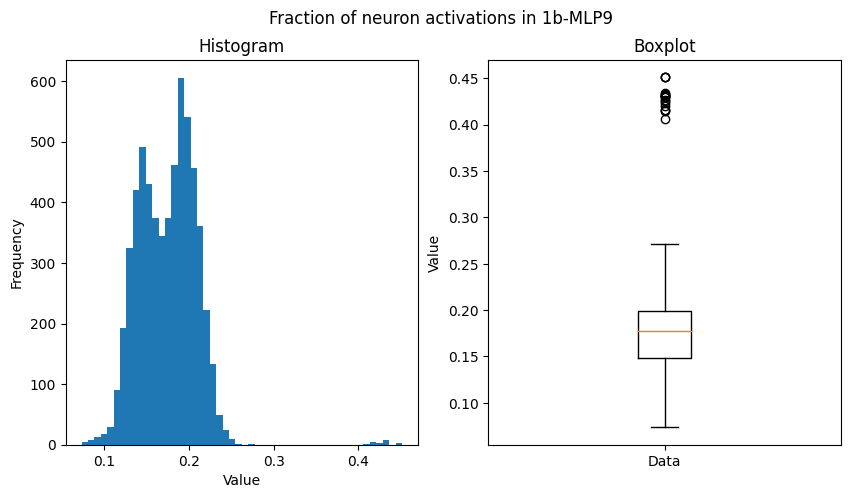

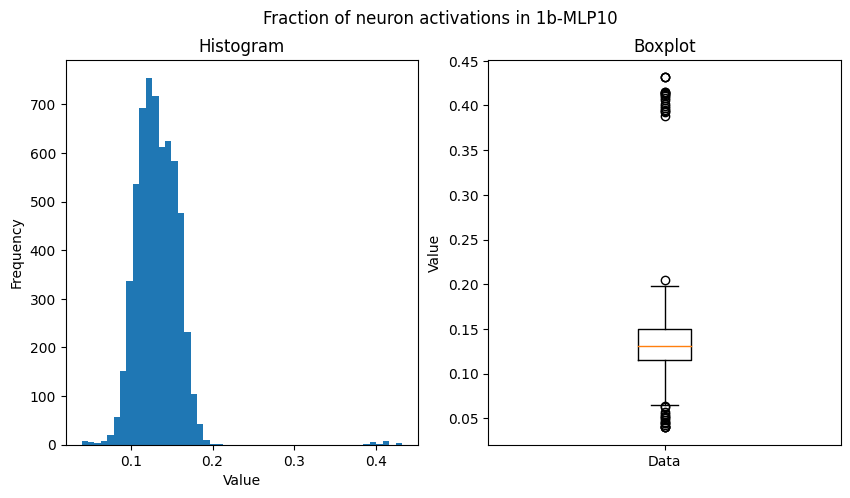

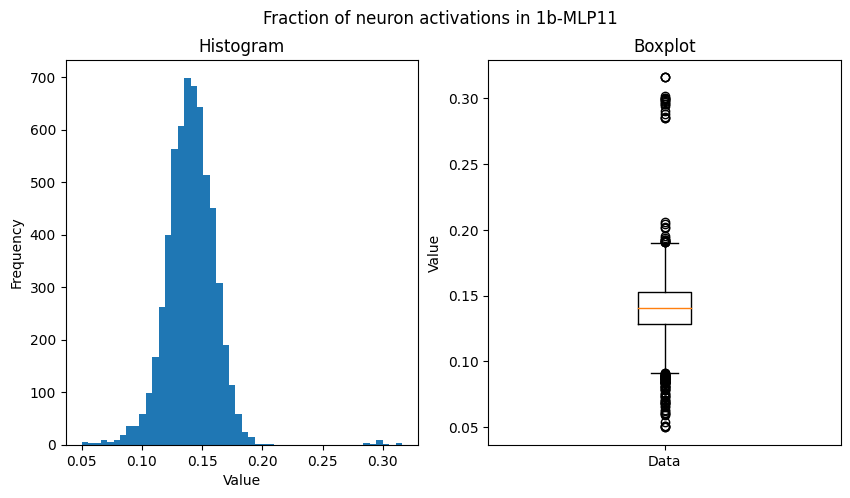

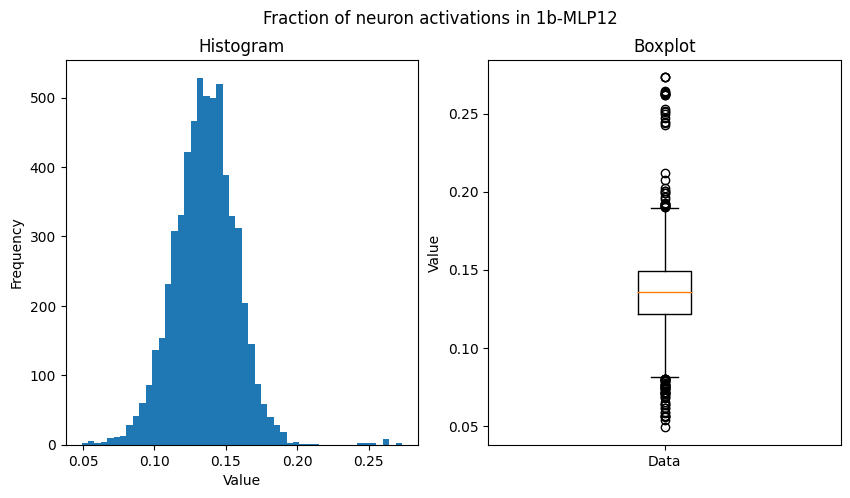

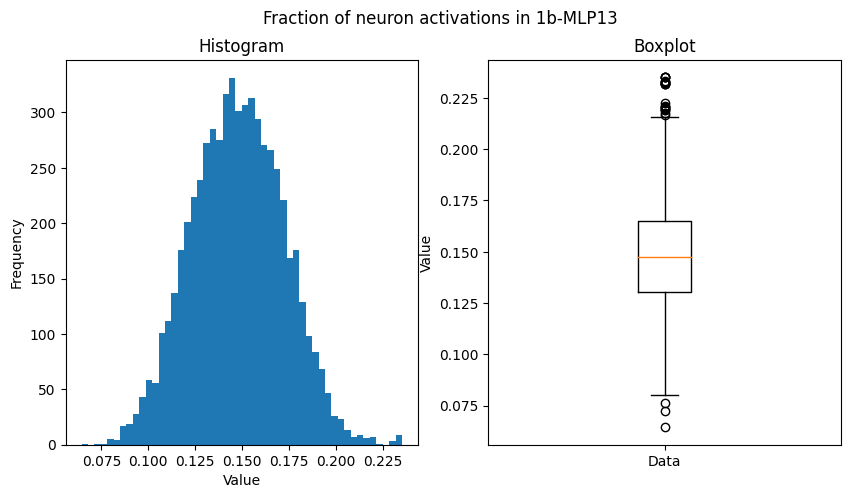

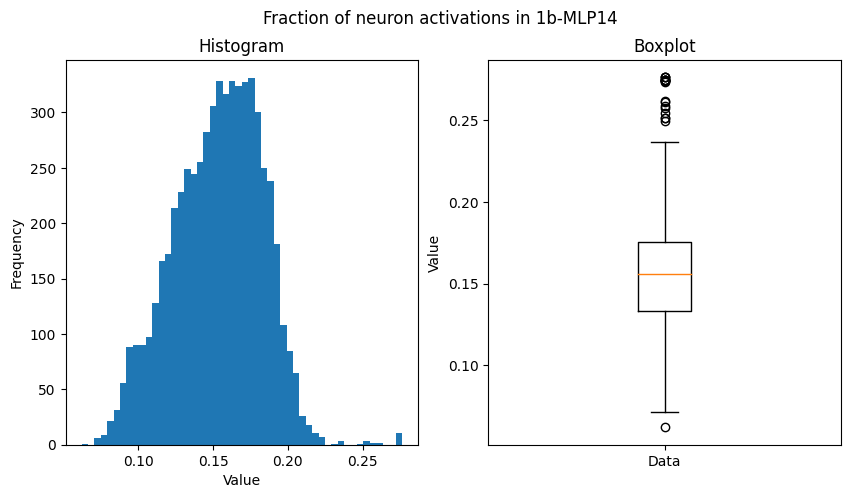

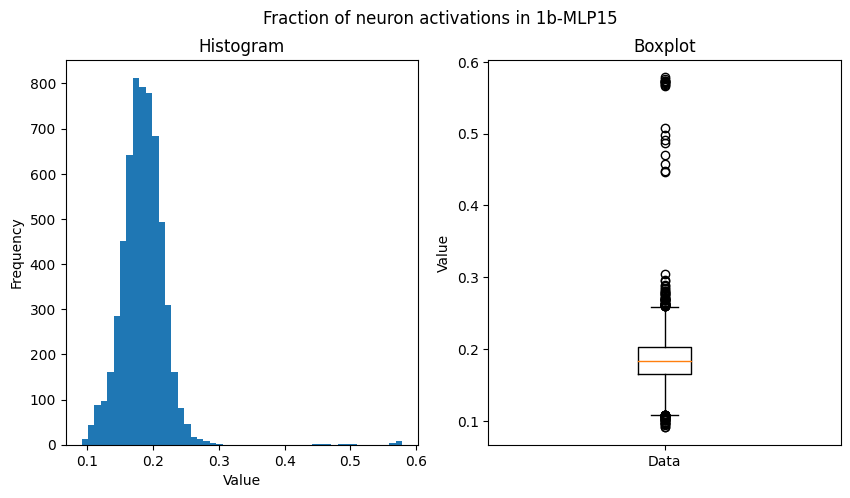

In [ ]:
data = {}
for model_size, model in yield_models(lens=True):
  post_all = get_many_post_all_layers(model, torch.arange(10,20), T)
  token_act_freq = (post_all > 0).float().mean(dim=-1)
  token_act_freq_layer_list = []
  for layer_id in range(get_n_layers(model)):
    token_act_freq_layer = token_act_freq[:,layer_id,:].reshape(-1)
    png_path = f'plots/mlp_token_act_frac_{model_size}-{layer_id}.png'
    hist_and_box(token_act_freq_layer, 
                title=f'Fraction of neuron activations in {model_size}-MLP{layer_id}',
                save_filename=png_path)
    token_act_freq_layer_list.append(token_act_freq_layer)
  torch.save(torch.stack(token_act_freq_layer_list), f'mlp_token_act_frac_{model_size}.pt')
  del post_all
  del model
  torch.cuda.empty_cache()

In [ ]:
from pythia_tools.models import n_layers_dict

In [ ]:
with open("plots.md", "w") as f:
  for model_size, n_layers in n_layers_dict.items():
    for layer_id in range(n_layers):
      png_path = f'plots/mlp_token_act_frac_{model_size}-{layer_id}.png'
      f.write(f"![Layer {layer_id} Plots]({png_path})\n\n")

In [ ]:
import os
import zipfile

def create_zip_archive(input_dir, output_path):
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(input_dir):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, input_dir))


In [ ]:
create_zip_archive('/content/plots', '/content/plots_token_act_frac.zip')